In [1]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import copy
import mne
import pickle
from LFCNN_decoder import SpatialParameters, TemporalParameters, ComponentsOrder, Predictions, WaveForms

2023-07-10 16:17:57.469141: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 16:17:57.514880: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 16:17:57.515900: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 16:17:58.352403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
def read_pkl(path: str):
    with open(
        path,
        'rb'
    ) as file:
        content = pickle.load(
            file
        )
    return content


def plot_patterns(
    patterns: np.ndarray, info: mne.Info,
    order: list[int] = None, axes: mpl.axes.Axes = None,
    cmap: str | mpl.colors.Colormap = 'RdBu_r',
    sensors: bool = True, colorbar: bool = False,
    res: int = 64, size: int = 1, cbar_fmt: str = '%3.1f',
    name_format: str = 'Latent\nSource %01d',
    show: bool = True, show_names: bool = False,
    outlines: str = 'head', contours: int = 6,
    image_interp: str ='linear'
) -> mpl.figure.Figure:
    if order is None:
        order = range(patterns.shape[1])

    info = copy.deepcopy(info)
    info.__setstate__(dict(_unlocked=True))
    info['sfreq'] = 1.
    patterns = mne.EvokedArray(patterns, info, tmin=0)
    return patterns.plot_topomap(
        times=order,
        axes=axes,
        cmap=cmap, colorbar=colorbar, res=res,
        cbar_fmt=cbar_fmt, sensors=sensors, units=None, time_unit='s',
        time_format=name_format, size=size, show_names=show_names, outlines=outlines,
        contours=contours, image_interp=image_interp, show=show)


def draw_sp(
    iy: int,
    waveforms: WaveForms,
    temporal_parameters: TemporalParameters,
    spatial_parameters: SpatialParameters,
    info: mne.Info,
    *,
    logscale: bool = False,
    suptitle: str = None,
    vmin: int | float = None,
    vmax: int | float = None,
    flim: int = 70,
    crop: int | float = .05,
    shift: bool = True,
    show: bool = True,
    figsize: tuple[int, int] = (10, 15)
) -> mpl.figure.Figure:
    data = spatial_parameters.patterns.copy()
    induced = waveforms.induced.copy()[
        iy,
        :flim,
        :
    ]
    crop *= induced.shape[1] / 2

    for i, ind_course in enumerate(induced):
        induced[i] /= ind_course.mean()

    fig = plt.figure(constrained_layout=False)
    fig.set_size_inches(*figsize)
    gs2 = fig.add_gridspec(
        nrows=9,
        ncols=2,
        bottom=.1,
        wspace=.05,
        hspace=.1
    )
    ax21 = fig.add_subplot(gs2[:3, :])
    ax22 = fig.add_subplot(gs2[3:6, :])
    ax23 = fig.add_subplot(gs2[6:, :])
    _ = plot_patterns(data, info, iy, ax21, name_format='', show=False)
    ax22_t = ax22.twinx()
    ax22_t.plot(sp.stats.zscore(waveforms.evoked[iy]), '#454545')
    pos = ax22.imshow(np.flip(induced, axis=0), cmap='RdBu_r', vmin=vmin, vmax=vmax)
    cb = fig.colorbar(pos, ax=ax22, pad=0.2, orientation='horizontal', aspect=75, fraction=.12)
    ax22.set_aspect('auto')
    ax22_t.set_aspect('auto')
    _ = ax23.plot(
        temporal_parameters.franges,
        sp.stats.zscore(temporal_parameters.finputs[iy]),
        temporal_parameters.franges,
        sp.stats.zscore(temporal_parameters.foutputs[iy]),
        temporal_parameters.franges,
        sp.stats.zscore(temporal_parameters.fresponces[iy]),
    )
    ax22_t.set_ylabel('Amplitude', labelpad=30, rotation=270)
    ax22_t.spines['top'].set_alpha(.2)
    ax22_t.spines['right'].set_alpha(.2)
    ax22_t.spines['left'].set_alpha(.2)
    ax22_t.spines['bottom'].set_alpha(.2)
    ax22_t.tick_params(axis='both', which='both',length=5, color='#00000050')
    ax22.spines['top'].set_alpha(.2)
    ax22.spines['right'].set_alpha(.2)
    ax22.spines['left'].set_alpha(.2)
    ax22.spines['bottom'].set_alpha(.2)
    ax22.tick_params(axis='both', which='both',length=5, color='#00000050')
    cb.outline.set_color('#00000020')
    cb.ax.tick_params(axis='both', which='both',length=5, color='#00000050')
    times = np.unique(np.round(waveforms.times, 1))

    if shift:
        times = np.round(times - times.mean(), 2)

    ranges = np.linspace(0, len(waveforms.times), len(times)).astype(int)
    ax22.set_xticks(ranges)
    ax22.set_xticklabels(times)
    freqs = [0] + [(i+1) for i in range(waveforms.induced.shape[-2]) if (i+1)%10==0]
    ax22.set_yticks(freqs)
    ax22.set_yticklabels(sorted(freqs, reverse=True))
    ax22.set_xlabel('Time (s)')
    ax22.set_ylabel('Frequency (Hz)', labelpad=15)
    ax23.set_ylim(-2, 11)
    ax23.set_yticks([i for i in range(11) if (i+1)%2])
    ax23.legend(['Filter input', 'Filtering pattern', 'Filter responce'], loc='upper right')
    ax23.spines['top'].set_alpha(.2)
    ax23.spines['right'].set_alpha(.2)
    ax23.spines['left'].set_alpha(.2)
    ax23.spines['bottom'].set_alpha(.2)
    ax23.tick_params(axis='both', which='both',length=5, color='#00000050')
    ax23.set_xlabel('Frequency (Hz)')
    ax23.set_ylabel('Amplitude')
    ax22_t.set_xlim([2 * crop, len(waveforms.times) - 2 * crop])
    ax23.set_xlim([0, 70])

    if logscale:
        ax23.set_yscale('log')
    if suptitle is None:
        fig.suptitle(f'Latent source {iy + 1}')
    else:
        fig.suptitle(suptitle)

    if show:
        plt.show()

    return fig


def info_pick_channels(info: mne.Info, ch_names: list[str]) -> mne.Info:
    sel = mne.pick_channels(info.ch_names, ch_names)
    return mne.pick_info(info, sel, copy=False, verbose=False)

/tmp/ipykernel_3643503/1632401123.py:6: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  content = pickle.load(


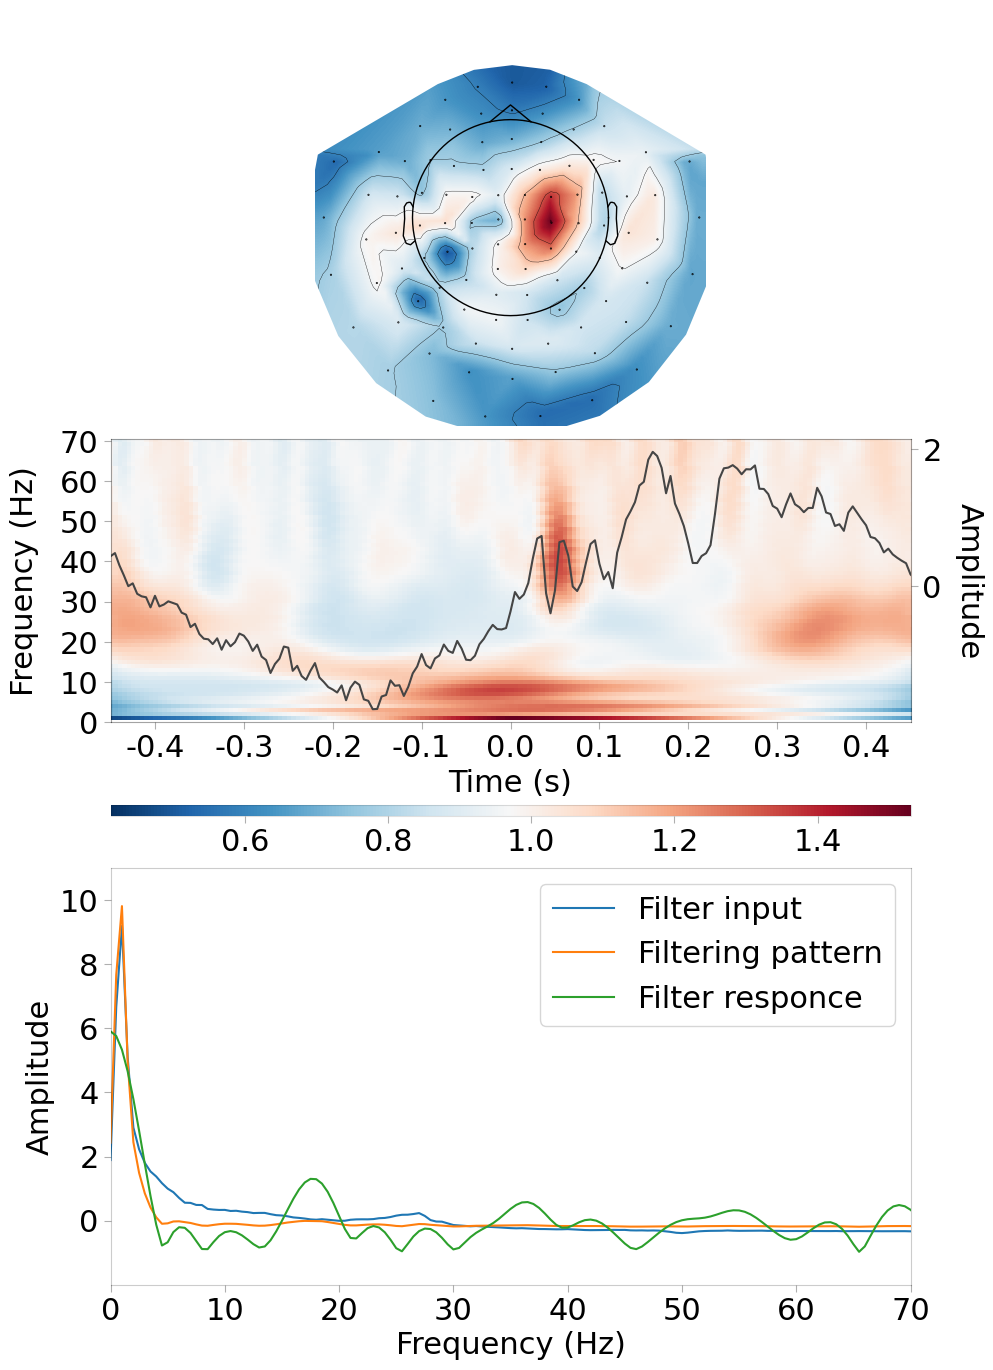

In [7]:
plt.rcParams.update({'font.size': 22})
subject_name = 'Az_Mar'
i=13
path = '/home/user/Downloads/Pics/Dumb/sample1.png'
cases_to_combine = ['LM LI', 'RM RI']

classification_name,\
    classification_postfix,\
    classification_prefix = None, '', ''
cases_to_combine = [case.split(' ') for case in cases_to_combine]

cases_to_combine = sorted(cases_to_combine, reverse=True)
class_names = ['&'.join(sorted(cases_combination, reverse=True)) for cases_combination in cases_to_combine]

if classification_name is None:
    classification_name = '_vs_'.join(class_names)

model='LFCNN'
subjects_dir = os.path.join('../', 'Source', 'Subjects')
classification_name_formatted = "_".join(list(filter(lambda s: s not in (None, ""), [classification_prefix, classification_name, classification_postfix])))
subject_info_path = os.path.join(subjects_dir, subject_name, 'Info')
subject_parameters_path = os.path.join(subjects_dir, subject_name, model, 'Parameters')
spatial_parameters = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_spatial.pkl'))
temporal_parameters = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_temporal.pkl'))
waveforms = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_waveforms.pkl'))
orders = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_sorting.pkl'))

info = read_pkl(os.path.join(subject_info_path, os.listdir(subject_info_path)[0]))
info_pick_channels(
    info,
    list(
        filter(
            lambda ch_name: (ch_name[-1] == '2' or ch_name[-1] == '3') and 'meg' in ch_name.lower(),
            info['ch_names']
        )
    )
)

fig = draw_sp(i, waveforms, temporal_parameters, spatial_parameters, info, suptitle='')
plt.show()
plt.savefig(path)
plt.close()